# Walkthrough: Deformation Rate Spectrum from Real World Grain Size Distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from scipy.integrate import quad, quad_vec
import scipy.interpolate as intp
from scipy.special import gamma
import warnings

## Helper Functions

### `powspace`

This does the same as `numpy.logspace()`, but takes real start and end values instead of
powers of a chosen base. In any case, the result is independent of the chosen base:

$$
x_n = x_\text{start}\,{\Bigl(\frac{x_\text{end}}{x_\text{start}}\Bigr)} ^ {\frac{n}{N - 1}}
\quad,\quad
n = 0, 1, \dots, N-1
$$

In [2]:
def powspace(start: float, end: float, num: int = 50):
    """Numbers spaced evenly on a log scale.

    Parameters
    ----------
    start : float
        Start value of the sequence.
    end : float
        End value of the sequence.
    num : int
        Number of samples to generate.
    """
    if num < 2:
        raise ValueError(
            f'This function is meant to generate a range of several values, not {num=}.'
        )
    if start <= 0. or end <= 0.:
        raise ValueError(
            f'xlogspace produces log spaced values larger 0. Please choose start '
            f'and end appropriately. Got {start=} and {end=}.'
        )
    return start * (end / start) ** (np.arange(num) / (num - 1))

### `handle_y_q`

In [3]:
def handle_y_q(func):
    """A decorator which handles the array and scalar combinations of arguments
    `y` and `q` as they appear in the base functions and their integrals.
    """
    def handle(y, q):
        y, q = np.asarray(y), np.asarray(q)
        if q.ndim > 1:
            raise ValueError(f'q should be a scalar or 1D array-like. Got {q.ndim=}.')
        return_scalar = y.ndim < 1 and q.ndim < 1
        unpack_last = y.ndim > 0 and q.ndim == 0
        # print(f"{return_scalar=}, {unpack_last=}")
        y = y[..., None]
        ret = func(y, q)
        if return_scalar:
            return ret[0]
        elif unpack_last:
            # print(ret)
            return ret[..., 0]
        else:
            return ret
    return handle

## Kernels for Base Functions

Base functions can be split into two factors, a norming factor (subscript $_0$), and a 'kernel'
$K(y)$ which depends only on the fraction $y=x/\lambda_l$.
For example for $\nu_l(x)$:

$$
\nu_l(x) = \nu_{0,l}\,K_(y)
$$

The norming factors are relatively simple functions of $x, \lambda, q,\dots$ and do not depend
on the chosen kernel base (Grady, Weibull, Log-Exp).

### Grady Base

$$
K_\text{G}(y) = \frac{1}{1 + y^q}
$$

In [4]:
def kernel_grady(y, q):
    return 1 / (1 + y ** q)

$$
\frac{\nu_l(x)}{\nu_{0,l}} = K_\text{G}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [5]:
@handle_y_q
def grady_nu(y, q):
    return kernel_grady(y, q)

$$
\frac{\sigma_l(x)}{\sigma_{0,l}} = y^2\,K_\text{G}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [6]:
@handle_y_q
def grady_sig(y, q):
    return y ** 2 * kernel_grady(y, q)

$$
\frac{\mu_l(x)}{\mu_{0,l}} = y^3\,K_\text{G}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [7]:
@handle_y_q
def grady_mu(y, q):
    return y ** 3 * kernel_grady(y, q)

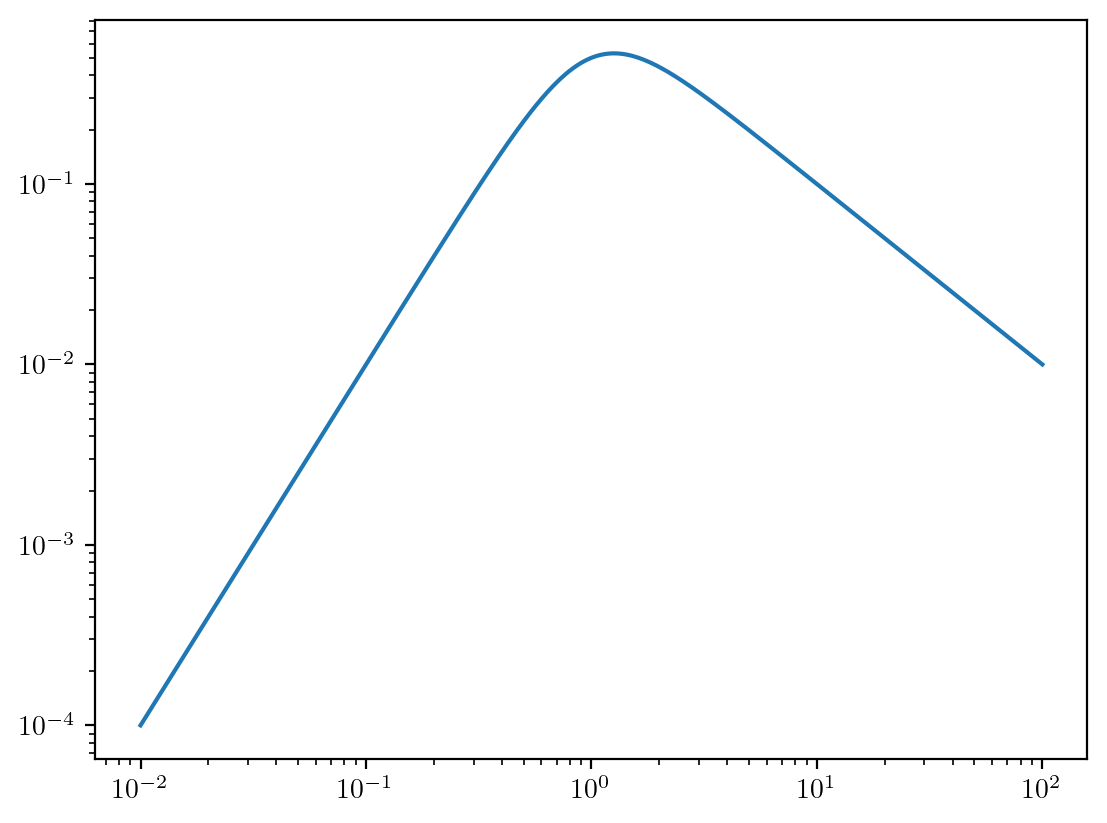

In [8]:
fig, ax = plt.subplots()

xp = np.logspace(-2, 2, 300)
ax.plot(xp, grady_sig(xp, 3))
# ax.plot(xp, xp ** 2)
ax.set(
    yscale='log', xscale='log'
);

$$
I_{2,\text{G}}(q) = \int_0^\infty\!\!y^2\,K_\text{G}(y)\,dy
$$

In [9]:
def grady_int2(q):
    if np.isscalar(q):
        ret = quad(lambda xx: grady_sig(xx, q), 0, np.inf)
    else:
        ret = quad_vec(lambda xx: grady_sig(xx, q), 0, np.inf)
    if ret[1] > 1e-8:
        warnings.warn(f"High error estimate ({ret[1]}) for {q=}.")
    return ret[0]

In [10]:
grady_int2(np.array([4, 4.1]))

array([1.11072073, 1.02637305])

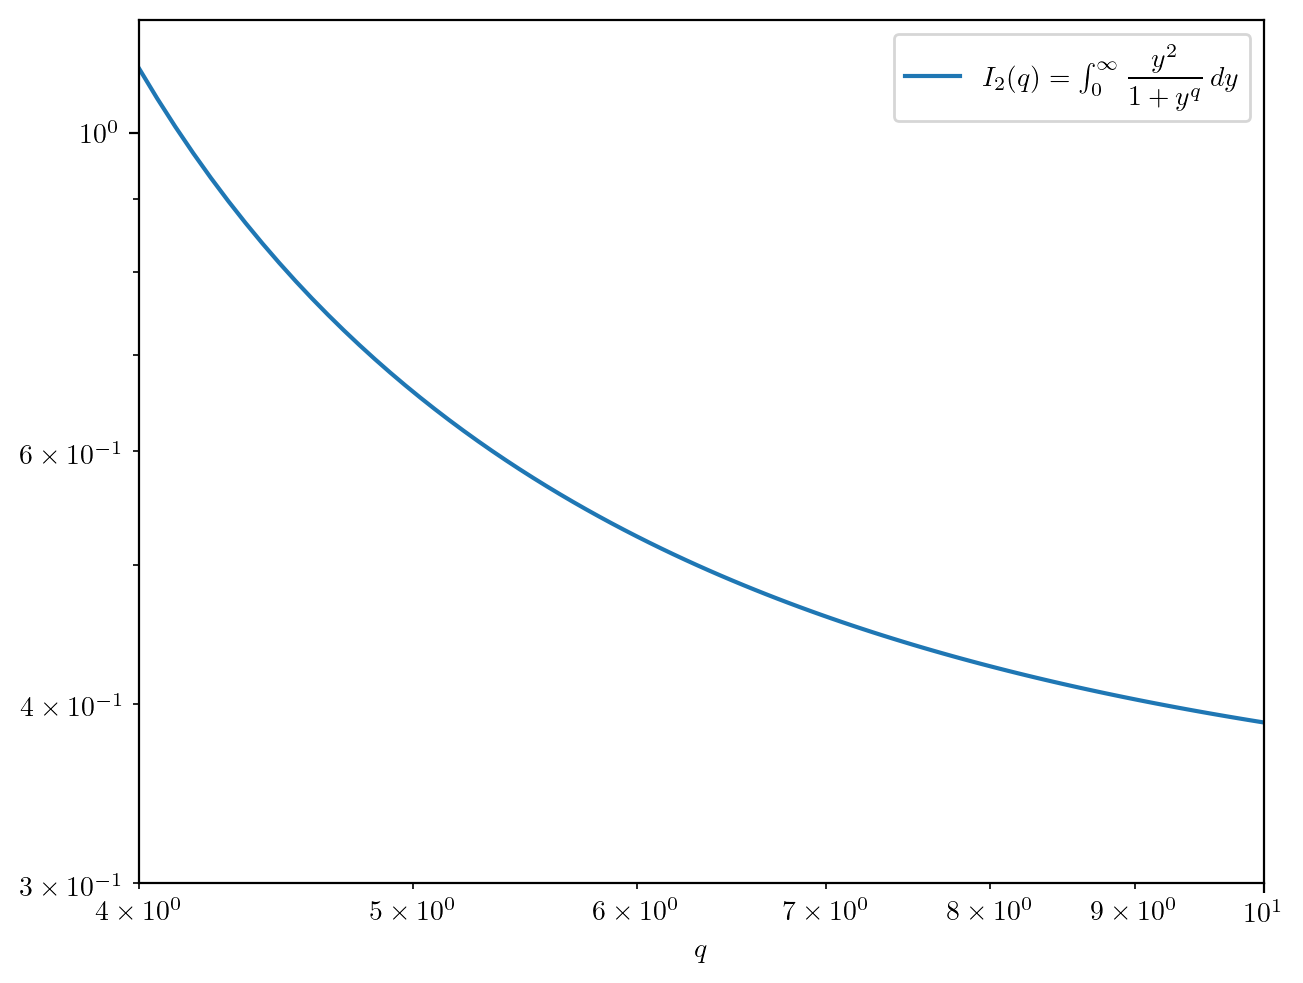

In [11]:
fig, ax = plt.subplots(constrained_layout=True)

q = np.linspace(4, 10, 100)

ax.plot(q, grady_int2(q), label=r'$I_2(q)=\int_0^\infty \dfrac{y^2}{1 + y^q}\,dy$')
ax.set(
    ylim=(.3, 1.2), yscale='log',
    xlim=(4, 10), xlabel=r'$q$', xscale='log'
)
ax.legend(loc='upper right')

### Weibull Base

In [12]:
def weibull(x, lmda, q):
    y = x / lmda
    return (q / lmda) * y ** (q - 1) * np.exp(-(y ** q))


def weibull_cumul(x, lmda, q):
    return 1. - np.exp(-((x / lmda) ** q))

$$
K_\text{W}(y) = y^{q-4}\,e^{-y^q}
$$

In [13]:
def kernel_weibull(y, q):
    return y ** (q - 4) * np.exp(-(y ** q))

$$
\frac{\nu_l(x)}{\nu_{0,l}} = K_\text{W}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [14]:
@handle_y_q
def weibull_nu(y, q):
    return kernel_weibull(y, q)

$$
\frac{\sigma_l(x)}{\sigma_{0,l}} = y^2\,K_\text{W}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [15]:
@handle_y_q
def weibull_sig(y, q):
    return y ** 2 * kernel_weibull(y, q)

$$
\frac{\mu_l(x)}{\mu_{0,l}} = y^3\,K_\text{W}(y)
\quad,\quad
y = \frac{x}{\lambda_l}
$$

In [16]:
@handle_y_q
def weibull_mu(y, q):
    return y ** 3 * kernel_weibull(y, q)

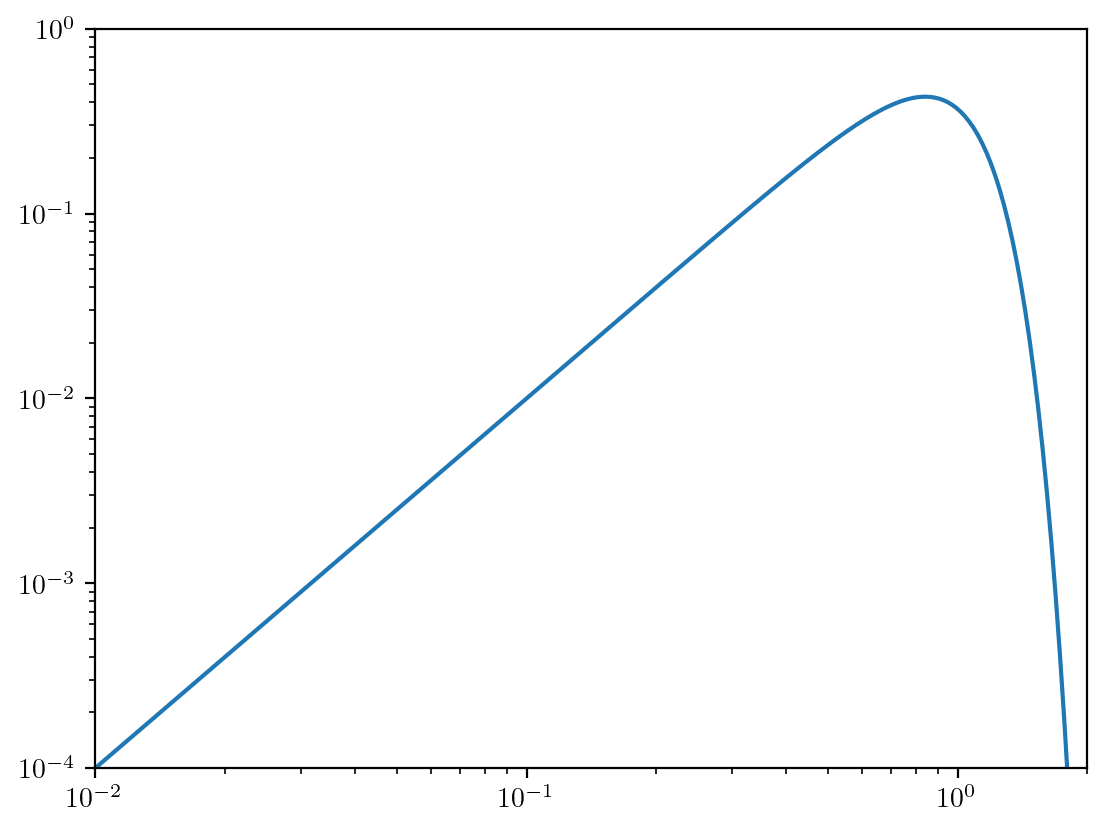

In [17]:
fig, ax = plt.subplots()

xp = np.logspace(-2, 1, 300)
ax.plot(xp, weibull_sig(xp, 4))
ax.set(
    yscale='log', xscale='log',
    ylim=(1e-4, 1), xlim=(1e-2, 2)
);

$$
I_2(q) = \int_0^\infty y^{q-2}e^{-y^q}dy = \frac{1}{q}\,\Gamma\bigl(1-1/q\bigr)
$$

In [18]:
def weibull_int2(q):
    if np.isscalar(q):
        ret = quad(lambda xx: weibull_sig(xx, q), 0, np.inf)
    else:
        ret = quad_vec(lambda xx: weibull_sig(xx, q), 0, np.inf)
    if ret[1] > 1e-8:
        warnings.warn(f"High error estimate ({ret[1]}) for {q=}.")
    return ret[0]

Check the accuracy of the integration routine for the Weibull base.

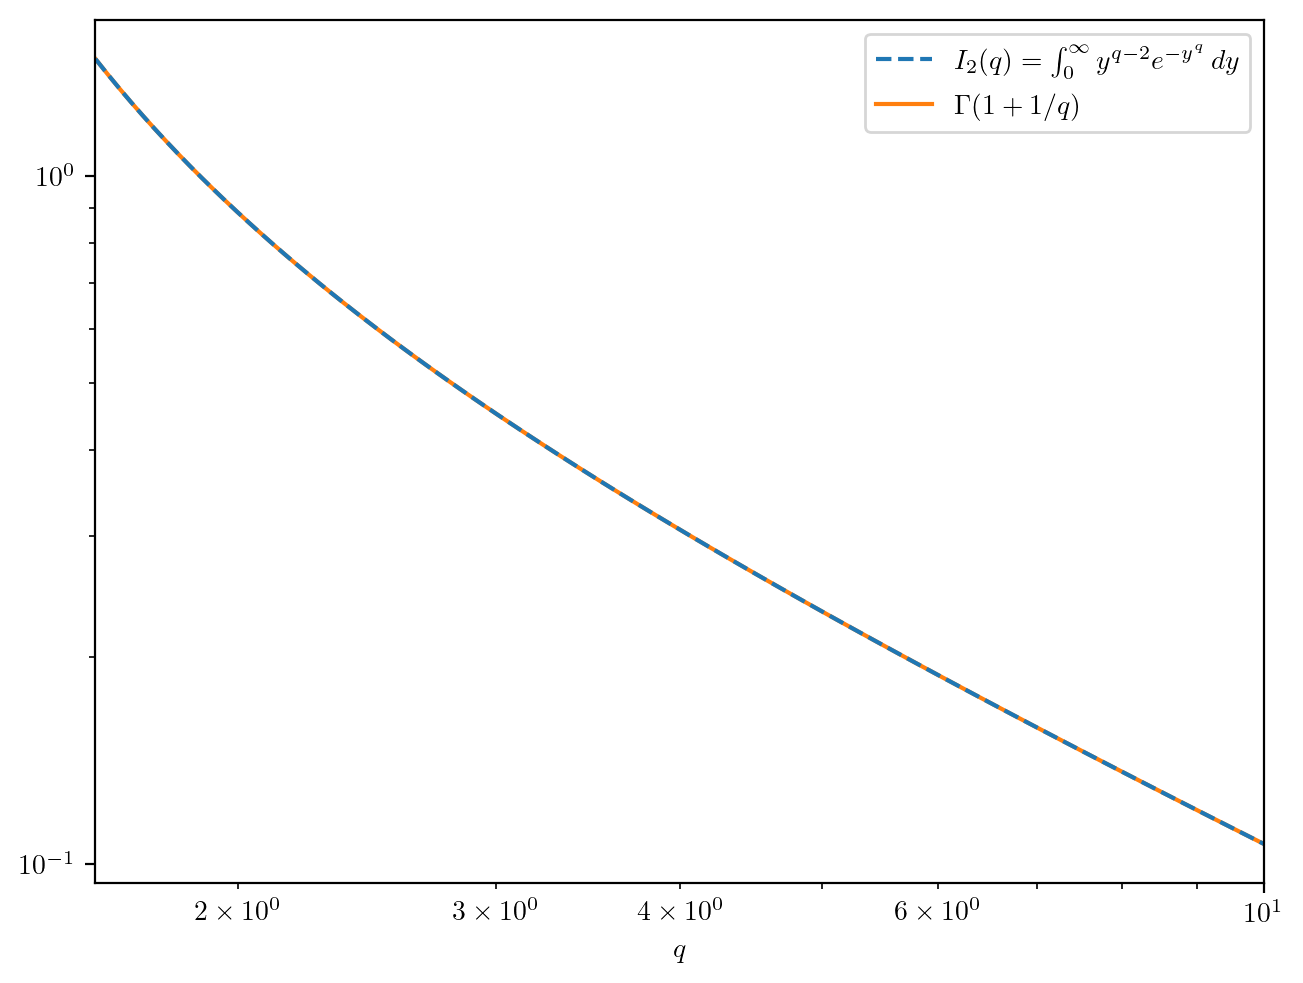

In [19]:
fig, ax = plt.subplots(constrained_layout=True)

q = powspace(1.6, 10, 100)

ax.plot(
    q, weibull_int2(q), zorder=1, ls='dashed',
    label=r'$I_2(q)=\int_0^\infty y^{q-2}e^{-y^q}\,dy$'
)
ax.plot(
    q, gamma(1 - 1 / q) / q, label=r'$\Gamma(1 + 1/q)$', ls='solid', zorder=-1
)
ax.set(
    # ylim=(.1, .31),
    yscale='log',
    xlim=(q[0], q[-1]),
    xlabel=r'$q$', xscale='log'
)
ax.legend(loc='upper right');

## Material Constants

In [20]:
m0 = 1.0
rho0 = 2.8e3

In [21]:
formfac_s = np.pi  # fs
formfac = 1 / 6    # f

## Grain Size Data

In [22]:
data = np.loadtxt(
    '../data/Buettner-et-al_2006_JGR_grainsizes.txt',
    skiprows=2, delimiter=','
)

In [23]:
data

array([[6.25000000e-02, 1.10400000e+00, 1.80700000e+00],
       [8.83883500e-02, 2.91000000e+00, 4.51000000e+00],
       [1.25000000e-01, 4.81500000e+00, 7.22300000e+00],
       [1.76776700e-01, 9.51200000e+00, 1.29900000e+01],
       [2.50000000e-01, 1.58700000e+01, 1.96900000e+01],
       [3.53553390e-01, 2.36900000e+01, 2.76400000e+01],
       [5.00000000e-01, 3.39900000e+01, 3.97700000e+01],
       [7.07106780e-01, 4.74900000e+01, 5.13400000e+01],
       [1.00000000e+00, 6.25800000e+01, 6.25800000e+01],
       [1.41421356e+00, 7.98000000e+01, 7.95700000e+01],
       [2.00000000e+00, 1.00000000e+02, 1.00000000e+02]])

In [24]:
xsieve, ams, ast = 1e-3 * data[:, 0], data[:, 1], data[:, 2]

In [25]:
x = np.sqrt(xsieve[1:] * xsieve[:-1])
x

array([7.43254457e-05, 1.05112053e-04, 1.48650891e-04, 2.10224107e-04,
       2.97301779e-04, 4.20448207e-04, 5.94603557e-04, 8.40896415e-04,
       1.18920711e-03, 1.68179283e-03])

In [26]:
diff_m_ams = (ams[1:] - ams[:-1]) / 100
diff_m_ams

array([0.01806, 0.01905, 0.04697, 0.06358, 0.0782 , 0.103  , 0.135  ,
       0.1509 , 0.1722 , 0.202  ])

In [27]:
mu_ams = diff_m_ams / (xsieve[1:] - xsieve[:-1])
mu_ams

array([697.61108761, 520.32618033, 907.16480579, 868.30284896,
       755.16600664, 703.327991  , 651.83766558, 515.20482447,
       415.72757782, 344.8355684 ])

## Mode Length Scales

In [28]:
qq = 6
Lmax = 2 * len(x)

In [29]:
lmdas = powspace(x[0], x[-1], Lmax)[::-1]
lmdas

array([1.68179283e-03, 1.42717069e-03, 1.21109815e-03, 1.02773883e-03,
       8.72139961e-04, 7.40098644e-04, 6.28048280e-04, 5.32962255e-04,
       4.52272181e-04, 3.83798522e-04, 3.25691722e-04, 2.76382247e-04,
       2.34538188e-04, 1.99029287e-04, 1.68896407e-04, 1.43325621e-04,
       1.21626233e-04, 1.03212115e-04, 8.75858804e-05, 7.43254457e-05])

## Norming Factors

In [30]:
def int2(base, q):
    base = base.lower()
    if base == 'grady':
        i2 = grady_int2(q)
    elif base == 'weibull':
        i2 = weibull_int2(q)
    return i2

$$
\nu_{0,l} = \frac{m_0}{\rho_p\,I_2\,f_S\lambda_0\,\lambda_l^3}
$$

In [31]:
def nu0s(base: str, lambdas, q, fs):
    i2 = int2(base, q)
    return m0 / (rho0 * i2 * lambdas[0] * lambdas ** 3)

$$
\sigma_{0,l} = \frac{m_0}{\rho_p\,I_2\,\lambda_0\,\lambda_l}
$$

In [32]:
def sigma0s(base: str, lambdas, q):
    i2 = int2(base, q)
    return m0 / (rho0 * i2 * lambdas[0] * lambdas)

$$
\mu_{0,l} = \frac{m_0\,f}{\rho_p\,I_2\,\lambda_0}
$$

In [33]:
def mu0s(base: str, lambdas, q, f):
    i2 = int2(base, q)
    return m0 * f / (i2 * lambdas[0])

## Base Functions

In [34]:
def handle_l_x(func):
    def broadcast(l, x):
        l, x = np.asarray(l), np.asarray(x)
        return_scalar = l.ndim < 1 and x.ndim < 1
        unpack_last = (x.ndim > 0) ^ (l.ndim > 0)
        x = x[..., None]
        ret = func(l, x)
        if return_scalar:
            return ret[0]
        elif unpack_last:
            return ret[..., 0]
        else:
            return ret
    return broadcast

$$
\nu_l(x) = \nu_{0,l}
$$

In [35]:
def make_nu_l(base):
    nu0l = nu0s(base, lmdas, qq, formfac_s)
    if base.lower() == 'weibull':
        func = weibull_nu
    elif base.lower() == 'grady':
        func = grady_nu
    @handle_l_x
    def nu_l(l, x):
        return nu0l[l] * func(x / lmdas[l], qq)
    return nu_l

In [36]:
def make_sig_l(base):
    sig0l = sigma0s(base, lmdas, qq)
    if base.lower() == 'weibull':
        func = weibull_sig
    elif base.lower() == 'grady':
        func = grady_sig
    @handle_l_x
    def sig_l(l, x):
        return sig0l[l] * func(x / lmdas[l], qq)
    return sig_l

In [37]:
def make_mu_l(base):
    mu0l = mu0s(base, lmdas, qq, formfac)
    if base.lower() == 'weibull':
        func = weibull_mu
    elif base.lower() == 'grady':
        func = grady_mu
    @handle_l_x
    def mu_l(l, x):
        return mu0l * func(x / lmdas[l], qq)
    return mu_l

## Interpolate the Grainsize Distribution

In [38]:
spl_ams = intp.CubicSpline(xsieve, ams / 100)
spl_ams_log = intp.CubicSpline(np.log(xsieve), np.log(ams / 100))

In [39]:
def amsfl(x):
    return np.exp(spl_ams_log(np.log(x)))

In [40]:
def amsfl_mu(x):
    lgx = np.log(x)
    return np.exp(spl_ams_log(lgx)) * spl_ams_log.derivative()(lgx) / x

In [41]:
ls = np.arange(Lmax)

In [42]:
ams

array([  1.104,   2.91 ,   4.815,   9.512,  15.87 ,  23.69 ,  33.99 ,
        47.49 ,  62.58 ,  79.8  , 100.   ])

In [43]:
quad(amsfl_mu, xsieve[0], xsieve[-1])[0] + ams[0] / 100

0.999999999955689

## Expansion Into Weibull Base

In [44]:
nu_l = make_nu_l('weibull')
sig_l = make_sig_l('weibull')
mu_l = make_mu_l('weibull')

In [45]:
def mu(x, a, q):
    assert np.isscalar(q), "mu: q needs to be a float scalar."
    return np.sum(a[None, :] * mu_l(ls, x), axis=1)

In [46]:
Kmax = 600

In [47]:
xk = powspace(x[0], x[-1], Kmax)

In [48]:
def sq(a):
    muk = amsfl_mu(xk)
    return np.sum(np.log(mu(xk, a, qq) / muk) ** 2)

In [49]:
def ofunc(a):
    sqa = sq(a)
    # ab = abs(a)
    return sqa #+ ab / Lmax #+ a.mean()

In [50]:
def dfdacond(a):
    """Absolute value of first difference (derivative). The maximum of left or
    right side is returned.
    """
    ret = np.empty_like(a)
    mean = a.mean()
    ret[[0, -1]] = np.abs(a[[1, -2]] - a[[0, -1]]) / mean
    ret[1:-1] = np.max(
        (np.abs(a[:-2] - a[1:-1]), np.abs(a[2:] - a[1:-1])),
        axis=0
    ) / mean
    return ret

In [51]:
def d2fdacond(a):
    """Absolute value of second difference (derivative)."""
    ret = np.empty_like(a)
    mean = a.mean()
    ret[[0, -1]] = 0.
    ret[1:-1] = np.abs(a[2:] - 2 * a[1:-1] + a[:-2]) / mean
    return ret

In [52]:
con1 = NonlinearConstraint(lambda x: x, 0, np.inf)  # a positive
con2 = NonlinearConstraint(dfdacond, 0., .33)      # upper bound for first difference
con3 = NonlinearConstraint(d2fdacond, 0, 0.2)

In [53]:
a = np.ones(Lmax)
res = minimize(
    fun=ofunc,
    x0=a,
    method='trust-constr',
    constraints=[con1, con2, con3],
    options=dict(maxiter=1000)
)

/home/ingo/.virtualenvs/home/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/home/ingo/.virtualenvs/home/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


In [54]:
res['success']

False

In [55]:
res

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 4.155940426303826
                 x: [ 9.478e-01  9.478e-01 ...  8.967e-01  1.263e+00]
               nit: 1000
              nfev: 20979
              njev: 999
              nhev: 0
          cg_niter: 2037
      cg_stop_cond: 2
              grad: [-1.922e+00  4.275e-01 ... -2.485e-01 -2.270e+00]
   lagrangian_grad: [ 1.214e-06  1.214e-06 ...  1.018e-06  1.453e-06]
            constr: [array([ 9.478e-01,  9.478e-01, ...,  8.967e-01,
                            1.263e+00]), array([ 2.692e-07,  2.000e-01, ...,  3.300e-01,
                            3.300e-01]), array([ 0.000e+00,  2.000e-01, ...,  2.000e-01,
                            0.000e+00])]
               jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                

In [56]:
lmdas

array([1.68179283e-03, 1.42717069e-03, 1.21109815e-03, 1.02773883e-03,
       8.72139961e-04, 7.40098644e-04, 6.28048280e-04, 5.32962255e-04,
       4.52272181e-04, 3.83798522e-04, 3.25691722e-04, 2.76382247e-04,
       2.34538188e-04, 1.99029287e-04, 1.68896407e-04, 1.43325621e-04,
       1.21626233e-04, 1.03212115e-04, 8.75858804e-05, 7.43254457e-05])

In [57]:
res['x']

array([0.94783681, 0.94783711, 0.72575657, 0.70072086, 0.8977493 ,
       1.06818172, 1.23869352, 1.21917403, 1.10160763, 1.20588106,
       1.30424085, 1.40260766, 1.50097672, 1.59934637, 1.47563487,
       1.12984225, 0.8300308 , 0.75230049, 0.89665134, 1.26308123])

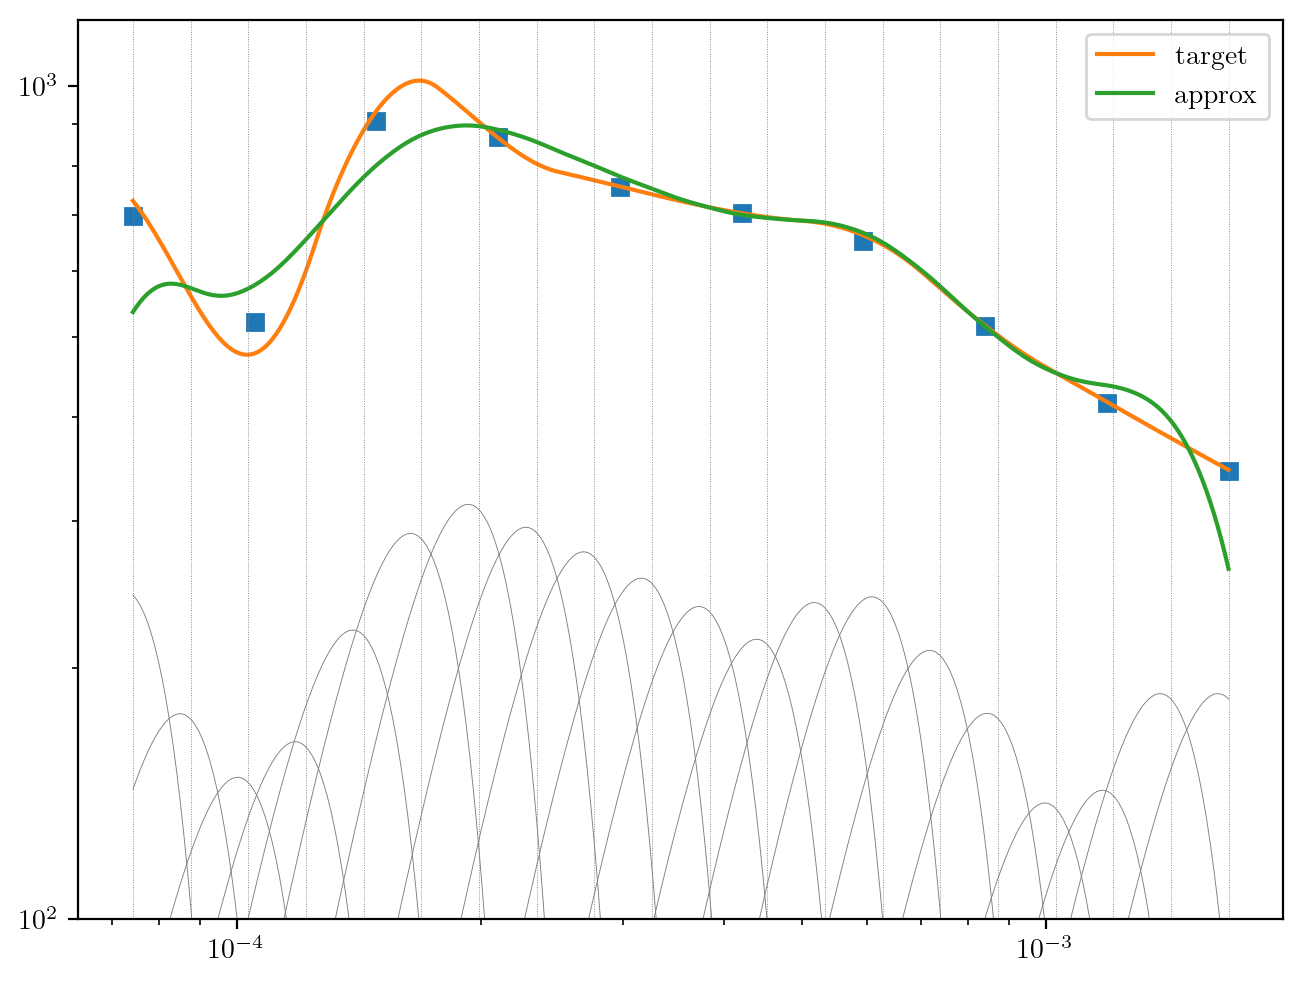

In [58]:
fig, ax = plt.subplots(constrained_layout=True)

xp = powspace(x[0], x[-1], 300)

ax.plot(x, mu_ams, 's')
ax.plot(xp, amsfl_mu(xp), label='target')
ax.plot(xp, mu(xp, res['x'], qq), label='approx')
for l in range(Lmax):
    aa = res['x'][l]
    ax.plot(xp, aa * mu_l(l, xp), color='gray', lw=.33)
ax.vlines(
    lmdas, 0, 1, colors='gray', linestyles='dotted', lw=.33,
    transform=ax.get_xaxis_transform()
)

ax.set(
    xscale='log', yscale='log',
    ylim=(1e2, 1.2e3)
)
ax.legend(loc='upper right');

### Map $\lambda$ to Deformation Rate

$$
\lambda = {\biggl(\frac{\gamma}{\rho{\dot\varepsilon}^2}\biggr)}^{1/3}
$$

$\gamma$: Brittle energy per area

In [59]:
gamma_over_rho = 1e-2  # this thing is kinda tricy
epsdots = np.sqrt(gamma_over_rho / lmdas ** 3)
epsdots

array([  1449.91070188,   1854.75316916,   2372.63530372,   3035.1199168 ,
         3882.58275297,   4966.67322773,   6353.46224935,   8127.46897231,
        10396.81189617,  13299.79824869,  17013.35324929,  21763.80298202,
        27840.66805054,  35614.30868221,  45558.49667864,  58279.28988145,
        74551.96893445,  95368.28748786, 121996.91555248, 156060.75978049])

In [60]:
lmdas

array([1.68179283e-03, 1.42717069e-03, 1.21109815e-03, 1.02773883e-03,
       8.72139961e-04, 7.40098644e-04, 6.28048280e-04, 5.32962255e-04,
       4.52272181e-04, 3.83798522e-04, 3.25691722e-04, 2.76382247e-04,
       2.34538188e-04, 1.99029287e-04, 1.68896407e-04, 1.43325621e-04,
       1.21626233e-04, 1.03212115e-04, 8.75858804e-05, 7.43254457e-05])

In [61]:
a = res['x']

In [62]:
surf_c = m0 / (rho0 * lmdas[0])
surf_c

0.2123584135715151

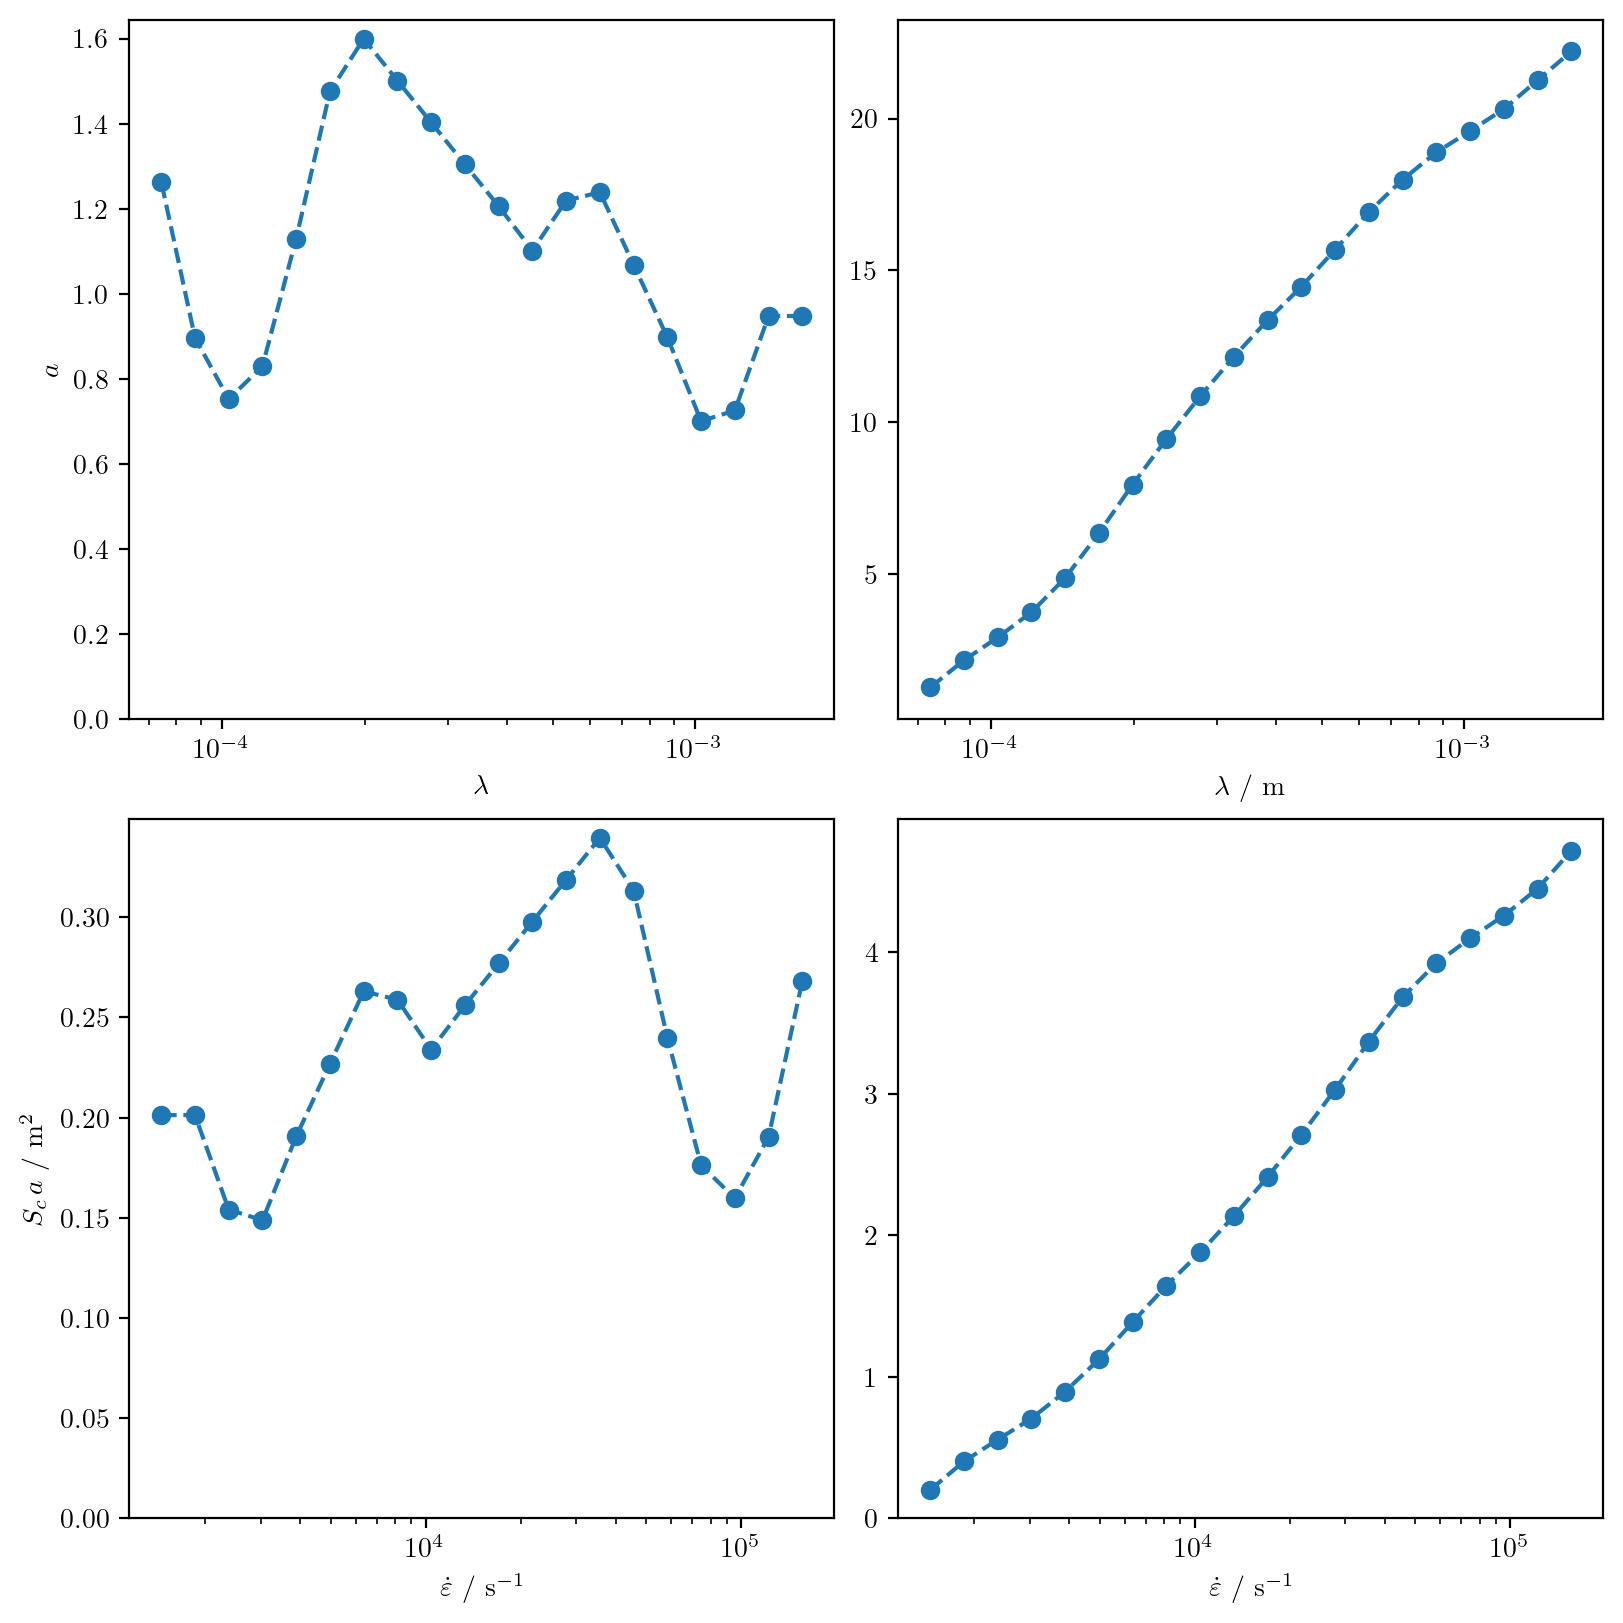

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, sharex='row',
    constrained_layout=True
)

ax1.plot(lmdas, a, 'o--')
ax1.set(
    xlabel=r'$\lambda$',
    ylabel=r'$a$', ylim=(0, None),
    xscale='log', yscale='linear'
)
ax2.plot(lmdas[::-1], np.cumsum(a[::-1]), 'o--')
ax2.set(xlabel=r'$\lambda\ /\ \mathrm{m}$')
ax3.plot(epsdots, surf_c * a, 'o--')
ax3.set(
    xscale='log', yscale='linear',
    ylim=(0, None),
    xlabel=r'$\dot{\varepsilon}\ /\ \mathrm{s^{-1}}$',
    ylabel=r'$S_c\,a\ /\ \mathrm{m^2}$'
)
ax4.plot(epsdots, np.cumsum(a) * surf_c, 'o--')
ax4.set(
    xscale='log', yscale='linear',
    ylim=(0, None),
    xlabel=r'$\dot{\varepsilon}\ /\ \mathrm{s^{-1}}$',
    # ylabel=r'$S_c\,a\ /\ \mathrm{m^2}$'
)
fig.set_size_inches(8, 8)

## Expansion Into Grady Base

In [64]:
qq = 10

In [65]:
nu_l = make_nu_l('grady')
sig_l = make_sig_l('grady')
mu_l = make_mu_l('grady')

In [66]:
def mu(x, a, q):
    assert np.isscalar(q), "mu: q needs to be a float scalar."
    return np.sum(a[None, :] * mu_l(ls, x), axis=1)

In [67]:
Kmax = 600

In [68]:
xk = powspace(x[0], x[-1], Kmax)

In [69]:
def sq(a):
    muk = amsfl_mu(xk)
    return np.sum(np.log(mu(xk, a, qq) / muk) ** 2)

In [70]:
def ofunc(a):
    sqa = sq(a)
    # ab = abs(a)
    return sqa #+ ab / Lmax #+ a.mean()

In [71]:
def dfdacond(a):
    """Absolute value of first difference (derivative). The maximum of left or
    right side is returned.
    """
    ret = np.empty_like(a)
    mean = a.mean()
    ret[[0, -1]] = np.abs(a[[1, -2]] - a[[0, -1]]) / mean
    ret[1:-1] = np.max(
        (np.abs(a[:-2] - a[1:-1]), np.abs(a[2:] - a[1:-1])),
        axis=0
    ) / mean
    return ret

In [72]:
def d2fdacond(a):
    """Absolute value of second difference (derivative)."""
    ret = np.empty_like(a)
    mean = a.mean()
    ret[[0, -1]] = 0.
    ret[1:-1] = np.abs(a[2:] - 2 * a[1:-1] + a[:-2]) / mean
    return ret

In [73]:
con1 = NonlinearConstraint(lambda x: x, 0, np.inf)  # a positive
con2 = NonlinearConstraint(dfdacond, 0., .33)      # upper bound for first difference
con3 = NonlinearConstraint(d2fdacond, 0, 0.3)

In [74]:
a = np.ones(Lmax)
res = minimize(
    fun=ofunc,
    x0=a,
    method='trust-constr',
    constraints=[con1, con2, con3],
    options=dict(maxiter=1000)
)

/home/ingo/.virtualenvs/home/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/home/ingo/.virtualenvs/home/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


In [75]:
res['success']

False

In [76]:
res

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 5.336627948293964
                 x: [ 1.399e+00  1.018e+00 ...  9.980e-01  1.379e+00]
               nit: 1000
              nfev: 20874
              njev: 994
              nhev: 0
          cg_niter: 2169
      cg_stop_cond: 2
              grad: [-7.771e-01  4.549e-01 ... -2.952e-01 -1.180e+00]
   lagrangian_grad: [-2.898e-06 -2.595e-06 ...  4.049e-07  1.035e-07]
            constr: [array([ 1.399e+00,  1.018e+00, ...,  9.980e-01,
                            1.379e+00]), array([ 3.300e-01,  3.300e-01, ...,  3.300e-01,
                            3.300e-01]), array([ 0.000e+00,  6.221e-02, ...,  3.947e-02,
                            0.000e+00])]
               jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                

In [77]:
lmdas

array([1.68179283e-03, 1.42717069e-03, 1.21109815e-03, 1.02773883e-03,
       8.72139961e-04, 7.40098644e-04, 6.28048280e-04, 5.32962255e-04,
       4.52272181e-04, 3.83798522e-04, 3.25691722e-04, 2.76382247e-04,
       2.34538188e-04, 1.99029287e-04, 1.68896407e-04, 1.43325621e-04,
       1.21626233e-04, 1.03212115e-04, 8.75858804e-05, 7.43254457e-05])

In [78]:
res['x']

array([1.39911598, 1.01794135, 0.70862911, 0.74584138, 0.78304256,
       1.16420314, 1.39269853, 1.27469689, 1.15694295, 1.03055592,
       1.25064867, 1.63180816, 1.67404414, 1.71628865, 1.41200579,
       1.03082354, 0.67335091, 0.66240853, 0.99799625, 1.3791743 ])

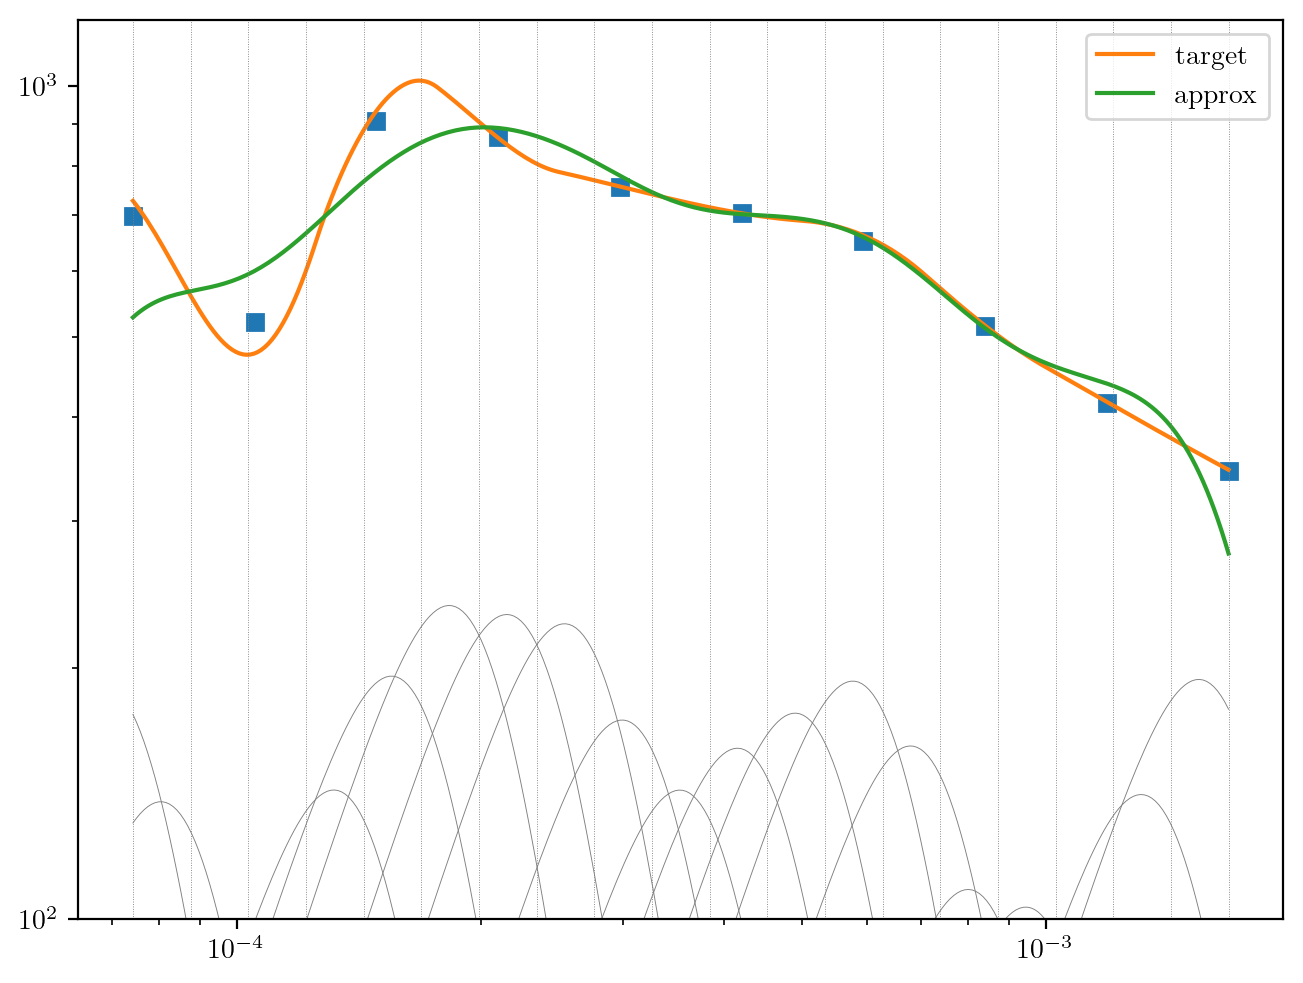

In [79]:
fig, ax = plt.subplots(constrained_layout=True)

xp = powspace(x[0], x[-1], 300)

ax.plot(x, mu_ams, 's')
ax.plot(xp, amsfl_mu(xp), label='target')
ax.plot(xp, mu(xp, res['x'], qq), label='approx')
for l in range(Lmax):
    aa = res['x'][l]
    ax.plot(xp, aa * mu_l(l, xp), color='gray', lw=.33)
ax.vlines(
    lmdas, 0, 1, colors='gray', linestyles='dotted', lw=.33,
    transform=ax.get_xaxis_transform()
)

ax.set(
    xscale='log', yscale='log',
    ylim=(1e2, 1.2e3)
)
ax.legend(loc='upper right');

### Map $\lambda$ to Deformation Rate

$$
\lambda = {\biggl(\frac{\gamma}{\rho{\dot\varepsilon}^2}\biggr)}^{1/3}
$$

$\gamma$: Brittle energy per area

In [80]:
gamma_over_rho = 1e-2  # this thing is kinda tricy
epsdots = np.sqrt(gamma_over_rho / lmdas ** 3)
epsdots

array([  1449.91070188,   1854.75316916,   2372.63530372,   3035.1199168 ,
         3882.58275297,   4966.67322773,   6353.46224935,   8127.46897231,
        10396.81189617,  13299.79824869,  17013.35324929,  21763.80298202,
        27840.66805054,  35614.30868221,  45558.49667864,  58279.28988145,
        74551.96893445,  95368.28748786, 121996.91555248, 156060.75978049])

In [81]:
lmdas

array([1.68179283e-03, 1.42717069e-03, 1.21109815e-03, 1.02773883e-03,
       8.72139961e-04, 7.40098644e-04, 6.28048280e-04, 5.32962255e-04,
       4.52272181e-04, 3.83798522e-04, 3.25691722e-04, 2.76382247e-04,
       2.34538188e-04, 1.99029287e-04, 1.68896407e-04, 1.43325621e-04,
       1.21626233e-04, 1.03212115e-04, 8.75858804e-05, 7.43254457e-05])

In [82]:
a = res['x']

In [83]:
surf_c = m0 / (rho0 * lmdas[0])
surf_c

0.2123584135715151

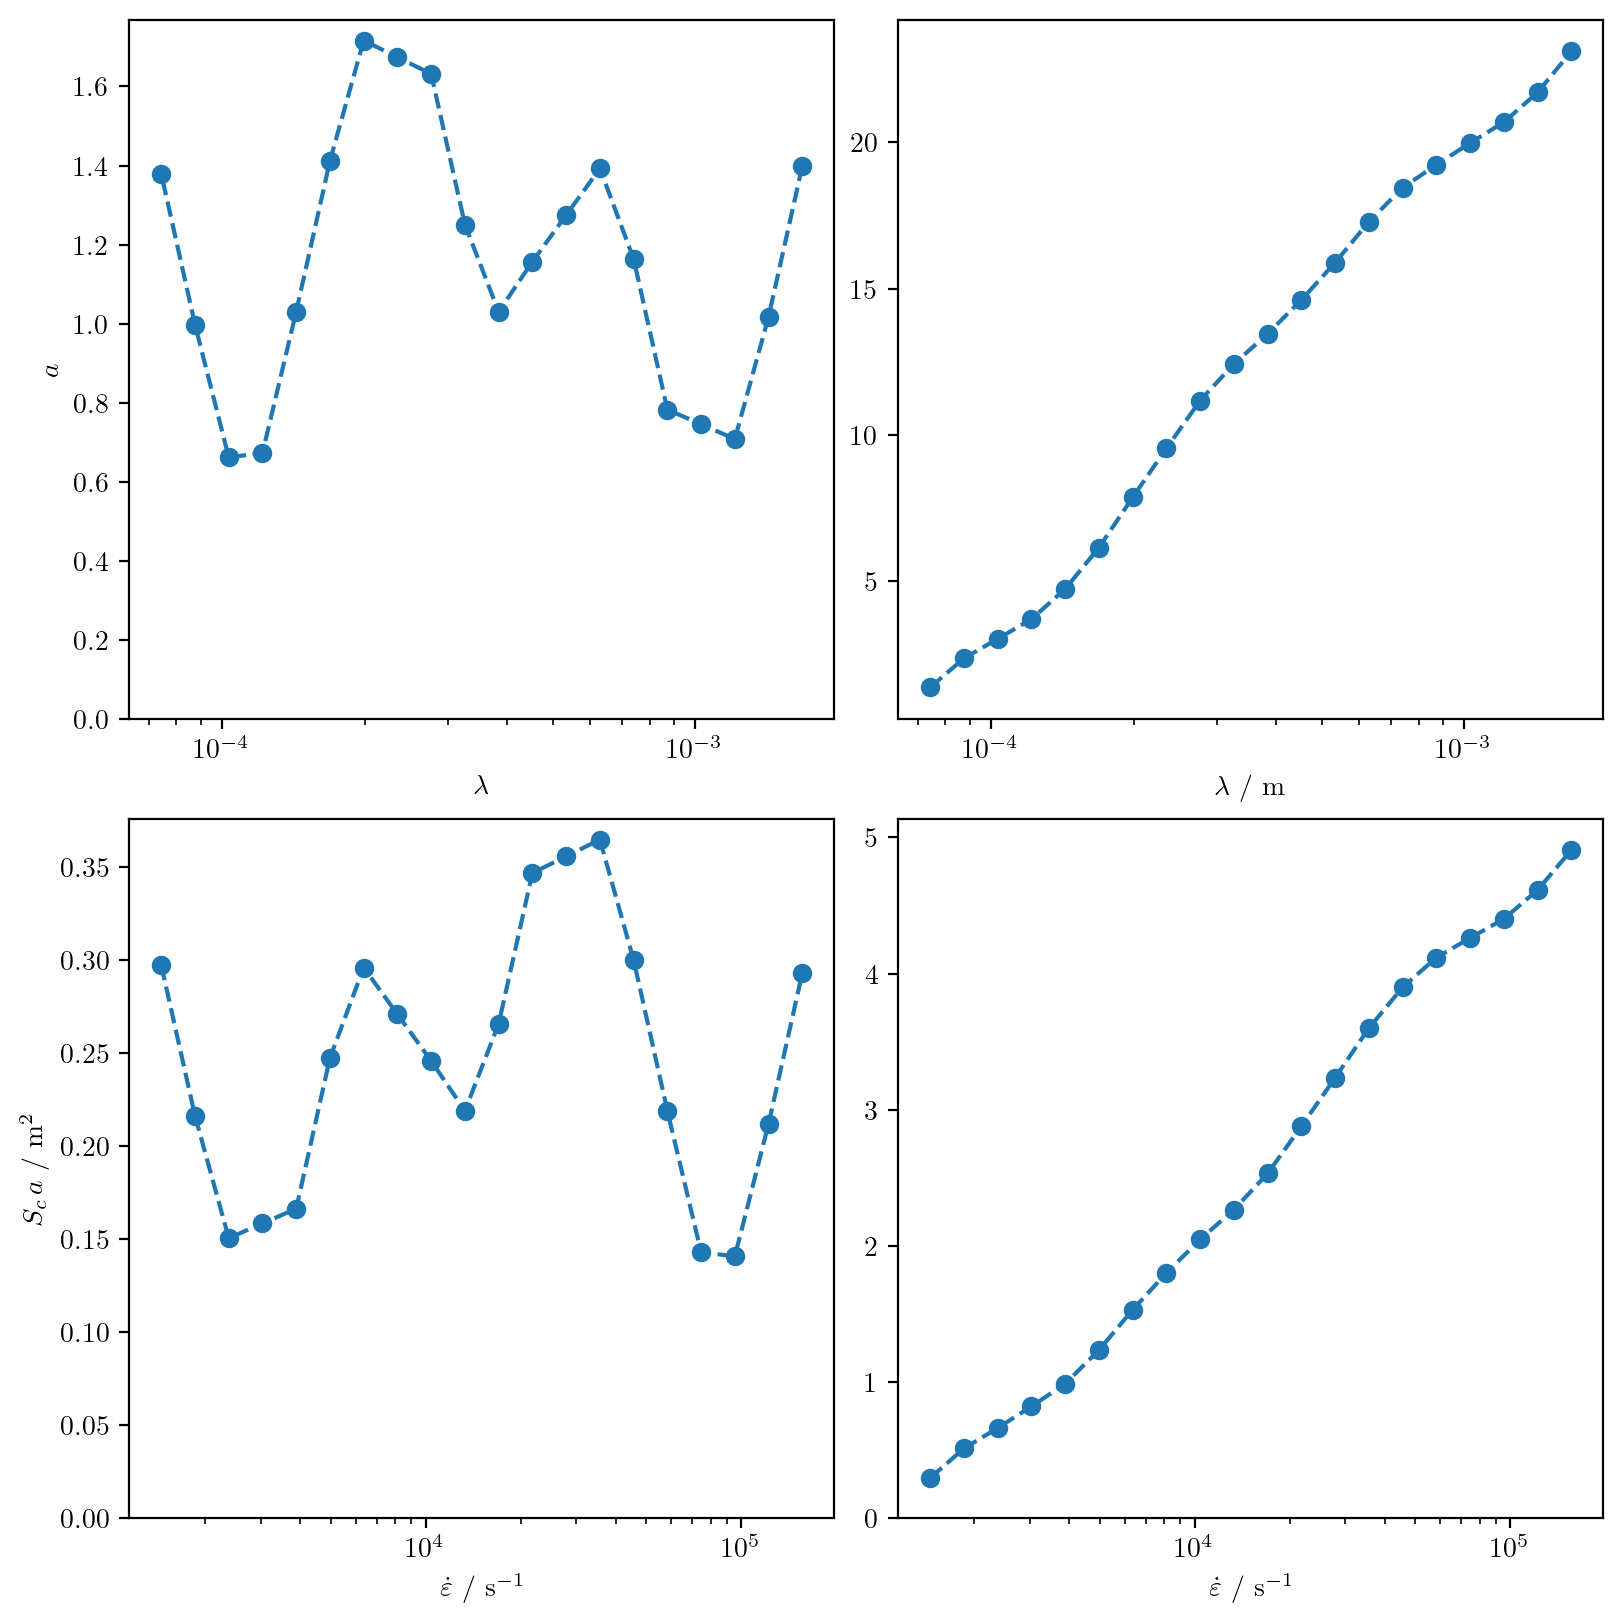

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, sharex='row',
    constrained_layout=True
)

ax1.plot(lmdas, a, 'o--')
ax1.set(
    xlabel=r'$\lambda$',
    ylabel=r'$a$', ylim=(0, None),
    xscale='log', yscale='linear'
)
ax2.plot(lmdas[::-1], np.cumsum(a[::-1]), 'o--')
ax2.set(xlabel=r'$\lambda\ /\ \mathrm{m}$')
ax3.plot(epsdots, surf_c * a, 'o--')
ax3.set(
    xscale='log', yscale='linear',
    ylim=(0, None),
    xlabel=r'$\dot{\varepsilon}\ /\ \mathrm{s^{-1}}$',
    ylabel=r'$S_c\,a\ /\ \mathrm{m^2}$'
)
ax4.plot(epsdots, np.cumsum(a) * surf_c, 'o--')
ax4.set(
    xscale='log', yscale='linear',
    ylim=(0, None),
    xlabel=r'$\dot{\varepsilon}\ /\ \mathrm{s^{-1}}$',
    # ylabel=r'$S_c\,a\ /\ \mathrm{m^2}$'
)
fig.set_size_inches(8, 8)